# Installing deepface

In [1]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=9dded517963810075a82decde48b6d844260e07391ac8457b23ac0a06d2e81ca
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


# **libraries**

In [2]:
import os
import glob
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

import imgaug.augmenters as iaa

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from sklearn.decomposition import PCA

from deepface import DeepFace

25-04-15 04:42:07 - Directory /root/.deepface has been created
25-04-15 04:42:07 - Directory /root/.deepface/weights has been created


# **Data Collection**

In [3]:
DATASET_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg"), recursive=True):
    person = os.path.basename(os.path.dirname(path)) 
    dataset.append({"person": person, "path": path})

dataset = pd.DataFrame(dataset)
dataset.head()

,person,path
0,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2,Bernard_Siegel,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...


# **Data Exploration**

In [4]:
print('size of data:',dataset.shape)
print('-------------------------------------------------------')
image_counts = dataset["person"].value_counts()
count_people_has_1_imgs = (image_counts == 1).sum()
print('count of people that has 1 imgs:',count_people_has_1_imgs)
print('-------------------------------------------------------')
count_people_has_more_than_10_imgs = (image_counts >= 10).sum()
print('count of people that has more than or equal 10 imgs:',count_people_has_more_than_10_imgs)
print('-------------------------------------------------------')
count_people_has_more_than_1_imgs = (image_counts > 1).sum()
print('count of people that has more than 1 imgs:',count_people_has_more_than_1_imgs)

size of data: (13233, 2)
-------------------------------------------------------
count of people that has 1 imgs: 4069
-------------------------------------------------------
count of people that has more than or equal 10 imgs: 158
-------------------------------------------------------
count of people that has more than 1 imgs: 1680


In [5]:
df_show = []
columns = dataset . columns 
for i in columns : 
    types = dataset[i] . dtypes
    
    unique_data = dataset[i] . nunique()
                   
    NAN_value=dataset[i].isnull().sum() 
        
    duplicated= dataset.duplicated().sum()    
    df_show . append ([i , types , unique_data , NAN_value,duplicated])
        
df_info = pd . DataFrame (df_show)
df_info . columns =['Columns' , 'Types' ,'Unique_Data' , 'NAN value',"Duplicated"]




df_info.style.highlight_max(color = 'pink', axis = 0)

,Columns,Types,Unique_Data,NAN value,Duplicated
0,person,object,5749,0,0
1,path,object,13233,0,0


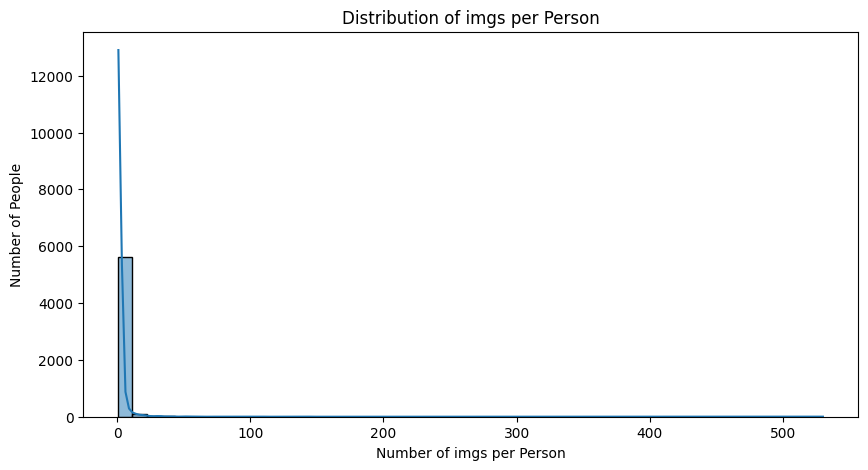

In [6]:
image_counts = dataset["person"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(image_counts, bins=50, kde=True)
plt.xlabel("Number of imgs per Person")
plt.ylabel("Number of People")
plt.title("Distribution of imgs per Person")
plt.show()


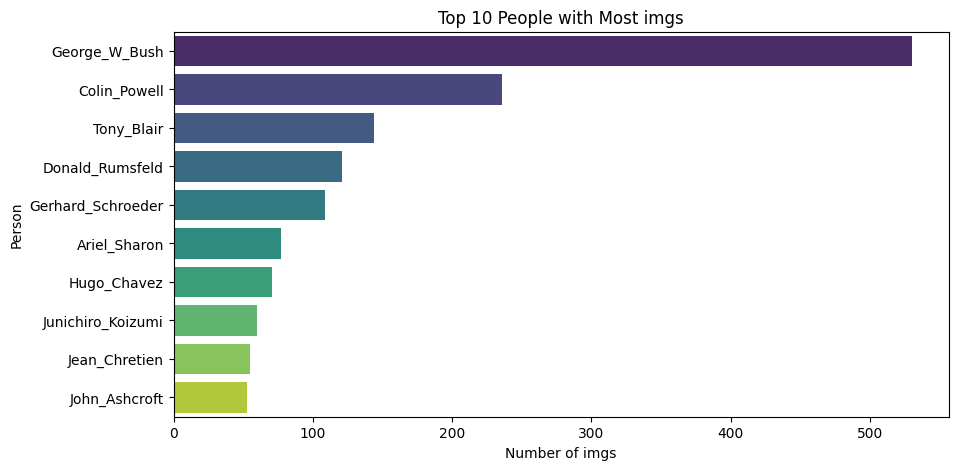

In [7]:
top_10_people = image_counts.head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_people.values, y=top_10_people.index, palette="viridis")
plt.xlabel("Number of imgs")
plt.ylabel("Person")
plt.title("Top 10 People with Most imgs")
plt.show()

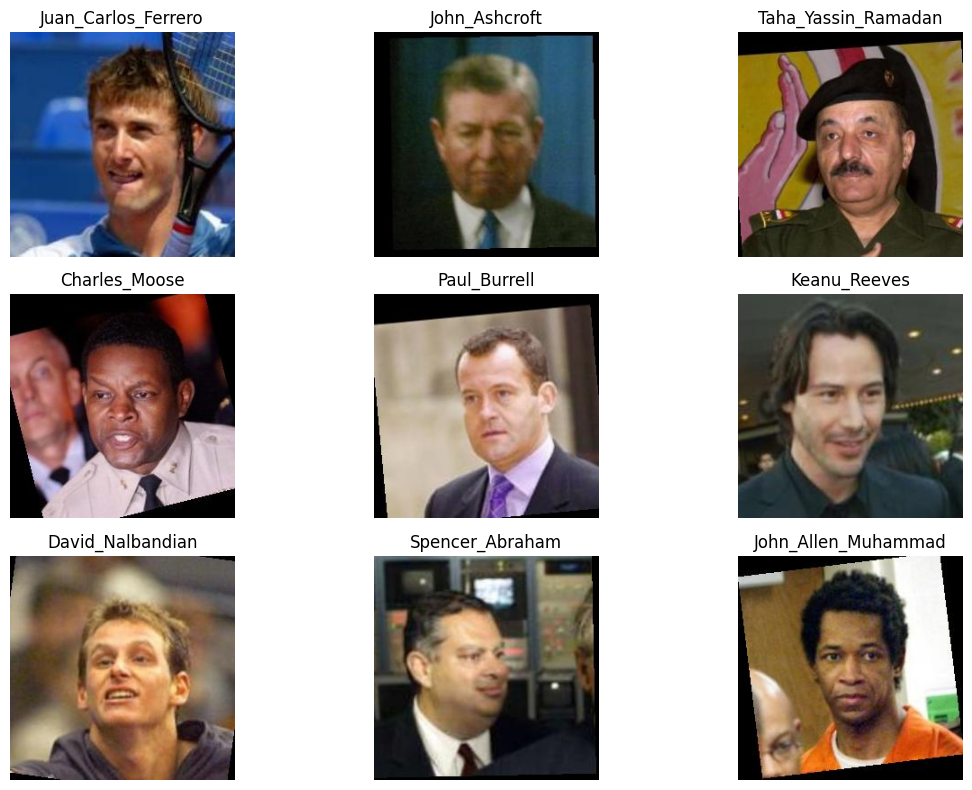

In [31]:
def plot_sample_imgs(dataset, num_samples=9):
    sample_people = random.sample(list(dataset["person"].unique()), num_samples)
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    
    for ax, person in zip(axes.flat, sample_people):
        person_images = dataset[dataset["person"] == person]["path"].values
        img_path = random.choice(person_images)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax.imshow(img)
        ax.set_title(person)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_sample_imgs(dataset)

# **Data Preprocessing**

In [9]:
# remove people with fewer than 5 images
filtered_dataset = dataset.groupby("person").filter(lambda x: len(x) >= 10)

# limit each person to max 30 images
def limit_images(group):
    return group.sample(n=min(len(group), 30), random_state=42)

dataset = filtered_dataset.groupby("person").apply(limit_images).reset_index(drop=True)

print("Dataset size after filtering:", dataset.shape)

Dataset size after filtering: (2974, 2)


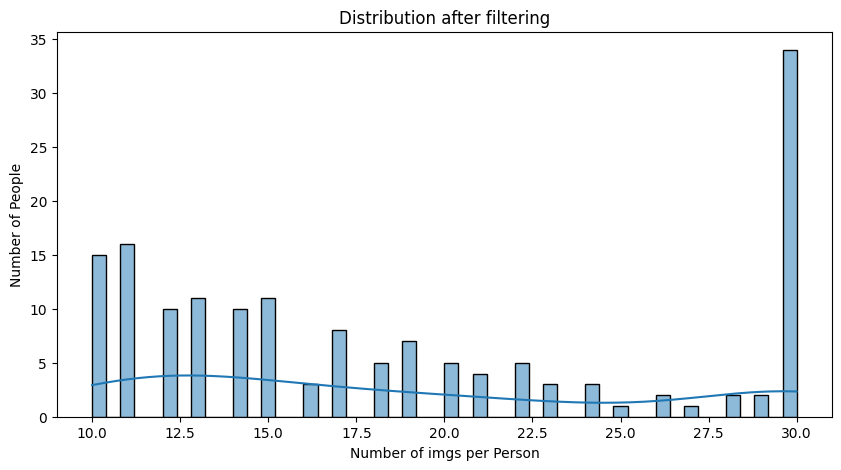

In [10]:
image_counts = dataset["person"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(image_counts, bins=50, kde=True)
plt.xlabel("Number of imgs per Person")
plt.ylabel("Number of People")
plt.title("Distribution after filtering")
plt.show()

In [11]:
print('size of data:',dataset.shape)
print('-------------------------------------------------------')
image_counts = dataset["person"].value_counts()
count_people_after_filtering = (image_counts > 1).sum()
print('count of people after filtering:',count_people_after_filtering)

size of data: (2974, 2)
-------------------------------------------------------
count of people after filtering: 158


# Data augmentation

In [12]:
# define augmentation pipeline
augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(rotate=(-20, 20)),  
    iaa.Multiply((0.8, 1.2)),  
    iaa.GaussianBlur(sigma=(0, 1.0))  
])

def augment_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = augmenters.augment_image(img)  
    return img


dataset["augmented_path"] = dataset["path"].apply(lambda x: augment_image(x))

In [13]:
img_path1=dataset.iloc[5,1]
img_path2=dataset.iloc[4,1]
img_path2

'/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Abdullah_Gul/Abdullah_Gul_0001.jpg'

In [14]:
#result = DeepFace.verify(img1_path=img_path1, img2_path=img_path2)

#print("DeepFace Verification Result:", result)


# Apply DeepFace

In [15]:
def get_embedding(image_path):
    try:
        embedding = DeepFace.represent(
            img_path=image_path, 
            model_name="VGG-Face", 
            enforce_detection=False 
        )[0]["embedding"]
        return embedding
    except Exception as e:
        print(f"Error extracting embedding for {image_path}: {e}")
        return None 

In [16]:
dataset["embedding"] = dataset["path"].apply(get_embedding)

25-04-15 04:43:44 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:07<00:00, 79.1MB/s] 


In [17]:
dataset["augmented_embedding"] = dataset["augmented_path"].apply(get_embedding)

In [18]:
dataset = dataset.dropna(subset=["embedding"]).reset_index(drop=True)

In [19]:
# Merge both embeddings
all_embeddings = dataset["embedding"].tolist() + dataset["augmented_embedding"].tolist()

# Create label mapping and assign numerical labels
label_mapping = {name: idx for idx, name in enumerate(dataset["person"].unique())}
dataset["label"] = dataset["person"].map(label_mapping)

# Ensure all labels match embeddings
all_labels = dataset["label"].tolist() + dataset["label"].tolist()

# Check for mismatches
assert len(all_embeddings) == len(all_labels), "Mismatch between embeddings and labels!"

In [20]:
dataset.size

17844

# PCA

In [21]:
X = np.array(all_embeddings)
y = np.array(all_labels)

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)*100:.2f}%")


Explained variance ratio: 54.36%


# SVM

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define parameter grid for tuning
param_grid = {
    "C": [0.1, 1, 10, 100],  
    "kernel": ["linear", "rbf"],  
    "gamma": ["scale", "auto"]
}

# Grid Search
svm = SVC(probability=True)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [23]:
# Best model
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized SVM Accuracy: {accuracy * 100:.2f}%")
print(f"Best Parameters: {grid_search.best_params_}")

Optimized SVM Accuracy: 92.86%
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [25]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      0.77      0.87        13
           3       0.80      0.92      0.86        13
           4       1.00      0.93      0.97        15
           5       0.90      1.00      0.95         9
           6       1.00      0.90      0.95        10
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       0.83      0.83      0.83         6
          10       1.00      1.00      1.00         3
          11       1.00      0.91      0.95        11
          12       0.90      0.82      0.86        11
          13       0.79      1.00      0.88        11
          14       0.85      1.00      0.92        11
          15       1.00      1.00      1.00         5
          16       1.00      0.86      0.92         7
          17       1.00    

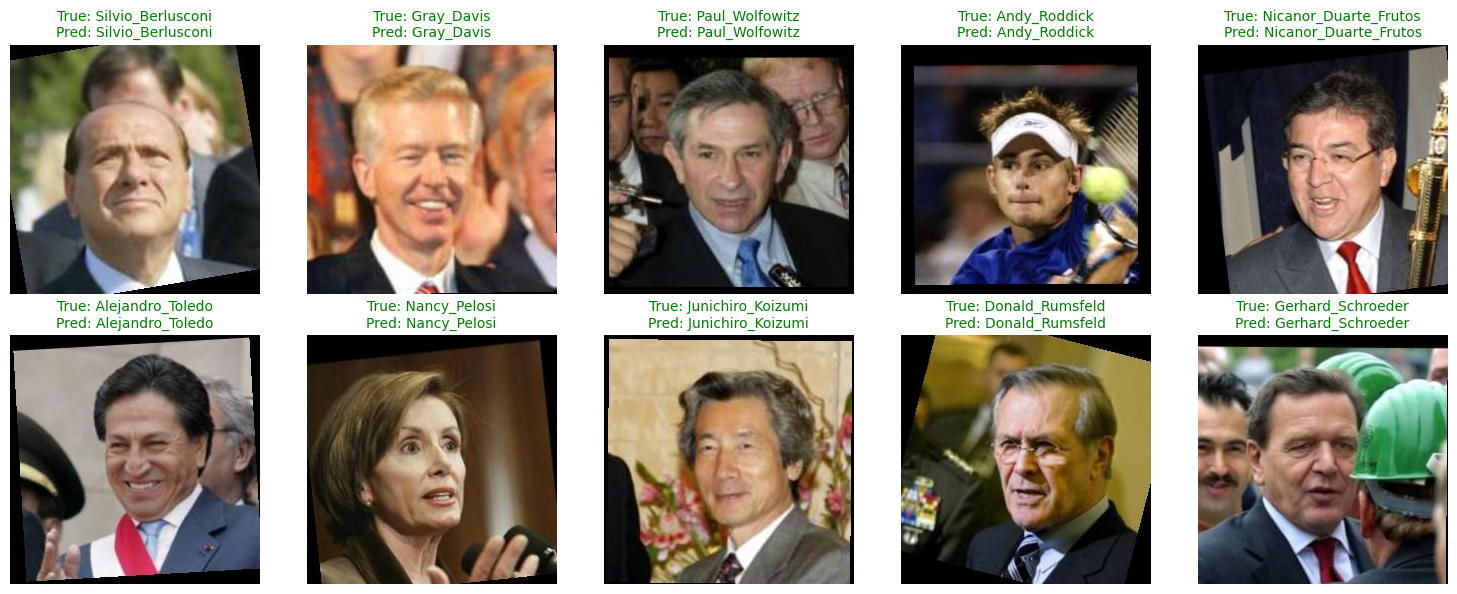

In [28]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Select random test samples
num_samples = min(10, len(X_test))  # Ensure we don't exceed available samples
sample_indices = random.sample(range(len(X_test)), num_samples)

# Get best trained SVM model from GridSearchCV
best_svm_model = grid_search.best_estimator_

# Create a 2-row grid for visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    embedding = X_test[idx].reshape(1, -1)  # Reshape for SVM prediction
    predicted_label = best_svm_model.predict(embedding)[0]  # Predict using best SVM model
    true_label = y_test[idx]  # Actual label

    # Get the corresponding image path (map label to name)
    true_person_data = dataset.loc[dataset["label"] == true_label]
    predicted_person_data = dataset.loc[dataset["label"] == predicted_label]

    # Handle cases where no match is found
    if true_person_data.empty or predicted_person_data.empty:
        print(f"Missing data for label {true_label} or {predicted_label}, skipping sample {idx}.")
        continue

    # Get only the first match to avoid multiple rows issue
    img_path = true_person_data.iloc[0]["path"]  
    person_name = true_person_data.iloc[0]["person"]
    predicted_name = predicted_person_data.iloc[0]["person"]

    img = cv2.imread(img_path)

    if img is None:
        print(f"Could not load image: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with actual and predicted names
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"True: {person_name}\nPred: {predicted_name}", 
                      fontsize=10, color="green" if person_name == predicted_name else "red")

plt.tight_layout()
plt.show()




# Save model

In [27]:
import joblib

# Save SVM model
joblib.dump(best_svm, "svm_model.pkl")
print(" SVM model saved as 'svm_model.pkl'")

 SVM model saved as 'svm_model.pkl'
